*That's not the same run i got my outputs  from, this changes slightly*

Use GPU if available

In [ ]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import re

import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


1. load dataset (works on kaggle)

In [ ]:
# Load the text data from the downloaded file
filename = "/kaggle/input/alicelab7/wonderland.txt"
with open(filename, 'r', encoding='utf-8') as f:
  raw_text = f.read()

In [ ]:
# Sample phrase

print(f"Number of unprocessed characters: {len(raw_text)}")
text_sample=(raw_text[100218:100503])
print(text_sample)

Number of unprocessed characters: 163916
She had quite forgotten the Duchess by this time, and was a little
startled when she heard her voice close to her ear. “You’re thinking
about something, my dear, and that makes you forget to talk. I can’t
tell you just now what the moral of that is, but I shall remember it in
a bit.”



In [ ]:
# Preprocessing and train-test subset

# Convert all characters to lowercase
raw_text = raw_text.lower()

# Remove non-alphanumeric characters
raw_text = re.sub(r'\n', ' ', raw_text)
raw_text = re.sub(r'[^A-Za-z ]+', '', raw_text)
raw_text = re.sub(r'  ', ' ', raw_text)
# added, replace double blank with blank

print(f"Number of unprocessed characters: {len(raw_text)}")

text_sample = text_sample.lower()
text_sample = re.sub(r'\n', ' ', text_sample)
text_sample = re.sub(r'[^A-Za-z ]+', '', text_sample)
print(text_sample)

# Create a set of unique characters in the text
unique_chars = set(raw_text)

# Sort the unique characters
chars = sorted(list(unique_chars))

# Create a dictionary mapping each unique character to a unique integer
char_to_int = dict((c, i) for i, c in enumerate(chars))

# Split the text into training and testing sets
train_start = int(len(raw_text) * 0.1)  # Starting index for training set (10% of text)
train_end = int(len(raw_text) * 0.8)  # Ending index for training set (80% of text)
test_start = train_end  # Starting index for testing set (remaining 20% of text)

raw_text_train = raw_text[train_start:train_end]  # Extract training text
raw_text_test = raw_text[test_start:]  # Extract testing text

# Calculate and print some summary statistics
n_chars_train = len(raw_text_train)
n_chars_test = len(raw_text_test)
n_vocab = len(chars)

print("Total Characters train:", n_chars_train)
print("Total Characters test:", n_chars_test)
print("Total Unique Characters (Vocabulary Size):", n_vocab)
print("Chars: ",chars)

Number of unprocessed characters: 153325
she had quite forgotten the duchess by this time and was a little startled when she heard her voice close to her ear youre thinking about something my dear and that makes you forget to talk i cant tell you just now what the moral of that is but i shall remember it in a bit 
Total Characters train: 107328
Total Characters test: 30665
Total Unique Characters (Vocabulary Size): 27
Chars:  [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Prepare the dataset of input to output pairs encoded as integers.

The model takes input sequences of 100 characters and predicts the character 101

In [ ]:
# Define the sequence length for character prediction
seq_length = 100

# List to store sequences of characters as integer indices
dataX = []

# List to store target characters (next character) as integer indices
dataY = []

# Loop through the training text with a stride of 1 character
for i in range(0, n_chars_train - seq_length, 1):
  # Extract an input sequence of length 'seq_length' from the training text
  seq_in = raw_text_train[i:i + seq_length]

  # Extract the target character (next character to predict)
  seq_out = raw_text_train[i + seq_length]

  # Convert characters in the input sequence to their integer indices using the mapping dictionary
  dataX.append([char_to_int[char] for char in seq_in])

  # Append the target character's integer index to the output list
  dataY.append(char_to_int[seq_out])

# Count the total number of training patterns (sequences-target character pairs)
n_patterns = len(dataX)
print("Total Patterns train: ", n_patterns)

# Convert the lists of integer indices (dataX and dataY) into PyTorch tensors
X_train = torch.tensor(dataX, dtype=torch.float32)
y_train = torch.tensor(dataY)

# Reshape the input sequences into a 3D tensor with dimensions:
#   - n_patterns: Number of training patterns
#   - seq_length: Length of the input sequence
#   - 1: Number of features (one-hot encoded characters can be represented as floats here)
X_train = X_train.reshape(n_patterns, seq_length, 1)

# Normalize the input sequences by dividing each element by the vocabulary size
# This helps the training process of the model
X_train = X_train / float(n_vocab)

# Prepare testing data (similar to training data preparation)

y_train = torch.tensor(dataY)

#test
dataX = []
dataY = []
for i in range(0, n_chars_test - seq_length, 1):
    seq_in = raw_text_test[i:i + seq_length]
    seq_out = raw_text_test[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns test: ", n_patterns)
# Convert the testing data lists to tensors, reshape, normalize, and create target tensor
X_test = torch.tensor(dataX, dtype=torch.float32).reshape(n_patterns, seq_length, 1)
X_test = X_test / float(n_vocab)
y_test = torch.tensor(dataY)


Total Patterns train:  107228
Total Patterns test:  30565


2. LSTM Model definition.

[LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)

[Explain](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Multi layers](https://www.researchgate.net/publication/324600237/figure/fig5/AS:616974627385344@1524109622521/Multivariate-LSTM-with-4-features-and-a-single-output-The-output-of-LSTM-at-time-t-is.png)

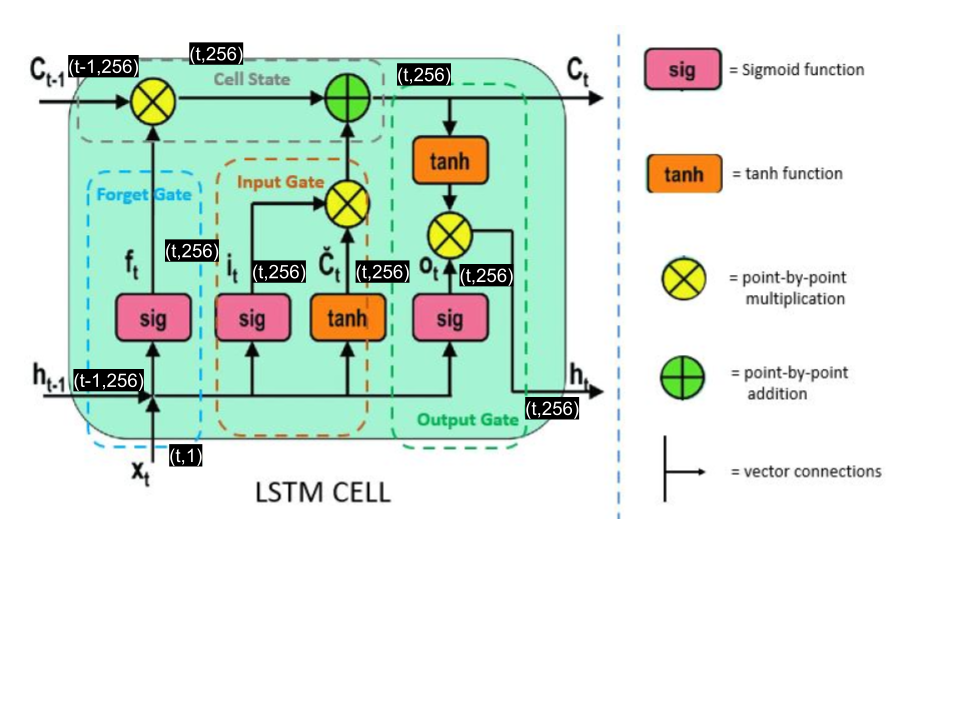

**LSTM** \
Best model: three stacked layers and no dropout

In [ ]:

class CharModel(nn.Module):
  
  def __init__(self, n_vocab):
   
    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=256,  # Hidden size of the LSTM layer
        num_layers=3,  # Number of LSTM layers stacked on top of each other
        batch_first=True,
    )

    # Define the linear layer for output
    self.linear = nn.Linear(256, n_vocab)  # Map LSTM output to vocabulary size (number of characters)

  def forward(self, x):

    # Pass the input sequence through the LSTM layer
    # The output (`x`) will be a tuple containing the output tensor and the hidden/cell states (not used here)
    x, _ = self.lstm(x)

    # Print the output shape for debugging purposes (can be commented out)
    # print(x.shape)

    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


**RNN**

In [ ]:
# RNN alternative

class CharModelRNN(nn.Module):

    def __init__(self, n_vocab):

        super().__init__()  # Call the superclass constructor

        # Define the RNN layer
        self.rnn = nn.RNN(
            input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
            hidden_size=256,  # Hidden size of the RNN layer
            num_layers=3,  # Number of RNN layers stacked on top of each other (but we take only the last output) *
            batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
            dropout=0.2  # Dropout rate for regularization
        )

        # Define the linear layer for output
        self.linear = nn.Linear(256, n_vocab)  # Map RNN output to vocabulary size (number of characters)

    def forward(self, x):


        # Pass the input sequence through the RNN layer
        x, h = self.rnn(x)  # Output, final hidden state (h_n)

        # Take only the last output from the sequence *
        x = x[:, -1, :]

        # Pass the RNN output through the linear layer to get logits for the next character prediction
        x = self.linear(x)

        return x


**GRU**

In [ ]:
# GRU alternative

class CharModelGRU(nn.Module):

    def __init__(self, n_vocab):

        super().__init__()  # Call the superclass constructor

        # Define the GRU layer
        self.gru = nn.GRU(
            input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
            hidden_size=256,  # Hidden size of the GRU layer
            num_layers=3,  # Number of GRU layers stacked on top of each other
            batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
            dropout=0.2
        )

        # Define the linear layer for output
        self.linear = nn.Linear(256, n_vocab)  # Map GRU output to vocabulary size (number of characters)

    def forward(self, x):

        # Pass the input sequence through the GRU layer
        x, h = self.gru(x)  # Output, final hidden state (h_n)

        # Take only the last output from the sequence
        x = x[:, -1, :]

        # Pass the GRU output through the linear layer to get logits for the next character prediction
        x = self.linear(x)

        return x


Train setup and dataloader

In [ ]:
# Hyperparameters for training
n_epochs = 60  # Number of training epochs, could early stoppage 
batch_size = 128  # Batch size for training

# Move the model to the appropriate device (CPU or GPU)
model = CharModel(n_vocab)                                 ## CharModel, CharModelRNN, CharModelGRU
model.to(device)

# Define optimizer for training (Adam optimizer with learning rate adjustment)
optimizer = optim.Adam(model.parameters())

# Define loss function (CrossEntropyLoss for character-level prediction)
loss_fn = nn.CrossEntropyLoss()

# Create training data loader
loader_train = data.DataLoader(
    data.TensorDataset(X_train, y_train),  # Dataset containing input sequences and target characters
    shuffle=True,  # Shuffle the data for each epoch
    batch_size=batch_size  # Batch size for training
)

# Create testing data loader (without shuffling and with batch size 1 for character-by-character prediction)
loader_test = data.DataLoader(
    data.TensorDataset(X_test, y_test),
    shuffle=False,  # Don't shuffle testing data
    batch_size=1  # Predict character by character for testing
)


Train the model

In [ ]:
from tqdm.auto import tqdm  # Import tqdm for progress bars

# Initialize variables for early stopping
best_model = None
best_loss = np.inf  # Initialize with positive infinity
patience = 8  # Number of epochs to wait for improvement before stopping

losses = []
accuracies = []

# Training loop
for epoch in tqdm(range(n_epochs)):
  # Set model to training mode
  model.train()

  # Iterate through training batches using the data loader
  for X_batch, y_batch in tqdm(loader_train):
    # Clear gradients from the previous iteration
    optimizer.zero_grad()

    # Get predictions for the current batch
    y_pred = model(X_batch.to(device))

    # Calculate loss for the current batch
    loss = loss_fn(y_pred, y_batch.to(device))

    # Backpropagate the loss to calculate gradients
    loss.backward()

    # Update model parameters based on the gradients
    optimizer.step()



  # Validation after each epoch
  model.eval()  # Set model to evaluation mode

  # Lists to store validation losses and accuracies
  validation_losses = []
  validation_accuracies = {"total":0,"correct":0}

  # Disable gradient calculation for validation (saves memory)
  with torch.no_grad():
    # Iterate through testing batches
    for X_batch, y_batch in loader_test:
      # Get predictions for the validation batch
      y_pred = model(X_batch.to(device))

      # Calculate validation loss for the current batch
      validation_loss = loss_fn(y_pred.to(device), y_batch.to(device)).cpu()

      # Append the validation loss to the list
      validation_losses.append(validation_loss)

      # Calculate accuracy current batch
      if int(y_pred.argmax().item())==int(y_batch.to(device).item()):
        validation_accuracies["total"]+=1
        validation_accuracies["correct"]+=1
      else:
        validation_accuracies["total"]+=1


    # Calculate the average validation loss
    avg_validation_loss = np.mean(validation_losses)

    losses.append(avg_validation_loss)

    # Calculate epoch accuracy
    accuracy = validation_accuracies["correct"]/validation_accuracies["total"]
    print(accuracy)
    accuracies.append(accuracy)


    # Track best model and save if validation loss improves
    if avg_validation_loss < best_loss:
      best_loss = avg_validation_loss
      best_model = model.state_dict()  # Save the model's state dictionary
      torch.save([best_model, char_to_int], "single-char.pth")  # Save model and character mapping
      patience = 8 # Reset patience counter for early stopping
      print("**BEST**", end="")  # Print indicator for best model
    else:
      patience -= 1  # Decrement patience counter if validation loss doesn't improve

    # Print epoch information and validation loss
    print("Epoch %d: Cross-entropy: %.4f" % (epoch, avg_validation_loss))

    # Implement early stopping
    if patience <= 0:
      print("Stop training!")
      break


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/838 [00:00<?, ?it/s]

0.28473744478979224
**BEST**Epoch 0: Cross-entropy: 2.5309


  0%|          | 0/838 [00:00<?, ?it/s]

0.3672501226893506
**BEST**Epoch 1: Cross-entropy: 2.2911


  0%|          | 0/838 [00:00<?, ?it/s]

0.39188614428267626
**BEST**Epoch 2: Cross-entropy: 2.1994


  0%|          | 0/838 [00:00<?, ?it/s]

0.4042532308195649
**BEST**Epoch 3: Cross-entropy: 2.1576


  0%|          | 0/838 [00:00<?, ?it/s]

0.40804842139702274
**BEST**Epoch 4: Cross-entropy: 2.1419


  0%|          | 0/838 [00:00<?, ?it/s]

0.4155079339113365
**BEST**Epoch 5: Cross-entropy: 2.1415


  0%|          | 0/838 [00:00<?, ?it/s]

0.4245705872730247
**BEST**Epoch 6: Cross-entropy: 2.1187


  0%|          | 0/838 [00:00<?, ?it/s]

0.41982659905120234
Epoch 7: Cross-entropy: 2.1410


  0%|          | 0/838 [00:00<?, ?it/s]

0.4273842630459676
Epoch 8: Cross-entropy: 2.1374


  0%|          | 0/838 [00:00<?, ?it/s]

0.42833306069033206
Epoch 9: Cross-entropy: 2.1825


  0%|          | 0/838 [00:00<?, ?it/s]

0.4261082938000981
Epoch 10: Cross-entropy: 2.1882


  0%|          | 0/838 [00:00<?, ?it/s]

0.4217896286602323
Epoch 11: Cross-entropy: 2.2582


  0%|          | 0/838 [00:00<?, ?it/s]

0.430426958939964
Epoch 12: Cross-entropy: 2.2561


  0%|          | 0/838 [00:00<?, ?it/s]

0.4205136594143628
Epoch 13: Cross-entropy: 2.2874


  0%|          | 0/838 [00:00<?, ?it/s]

0.42669720268280714
Epoch 14: Cross-entropy: 2.3329
Stop training!


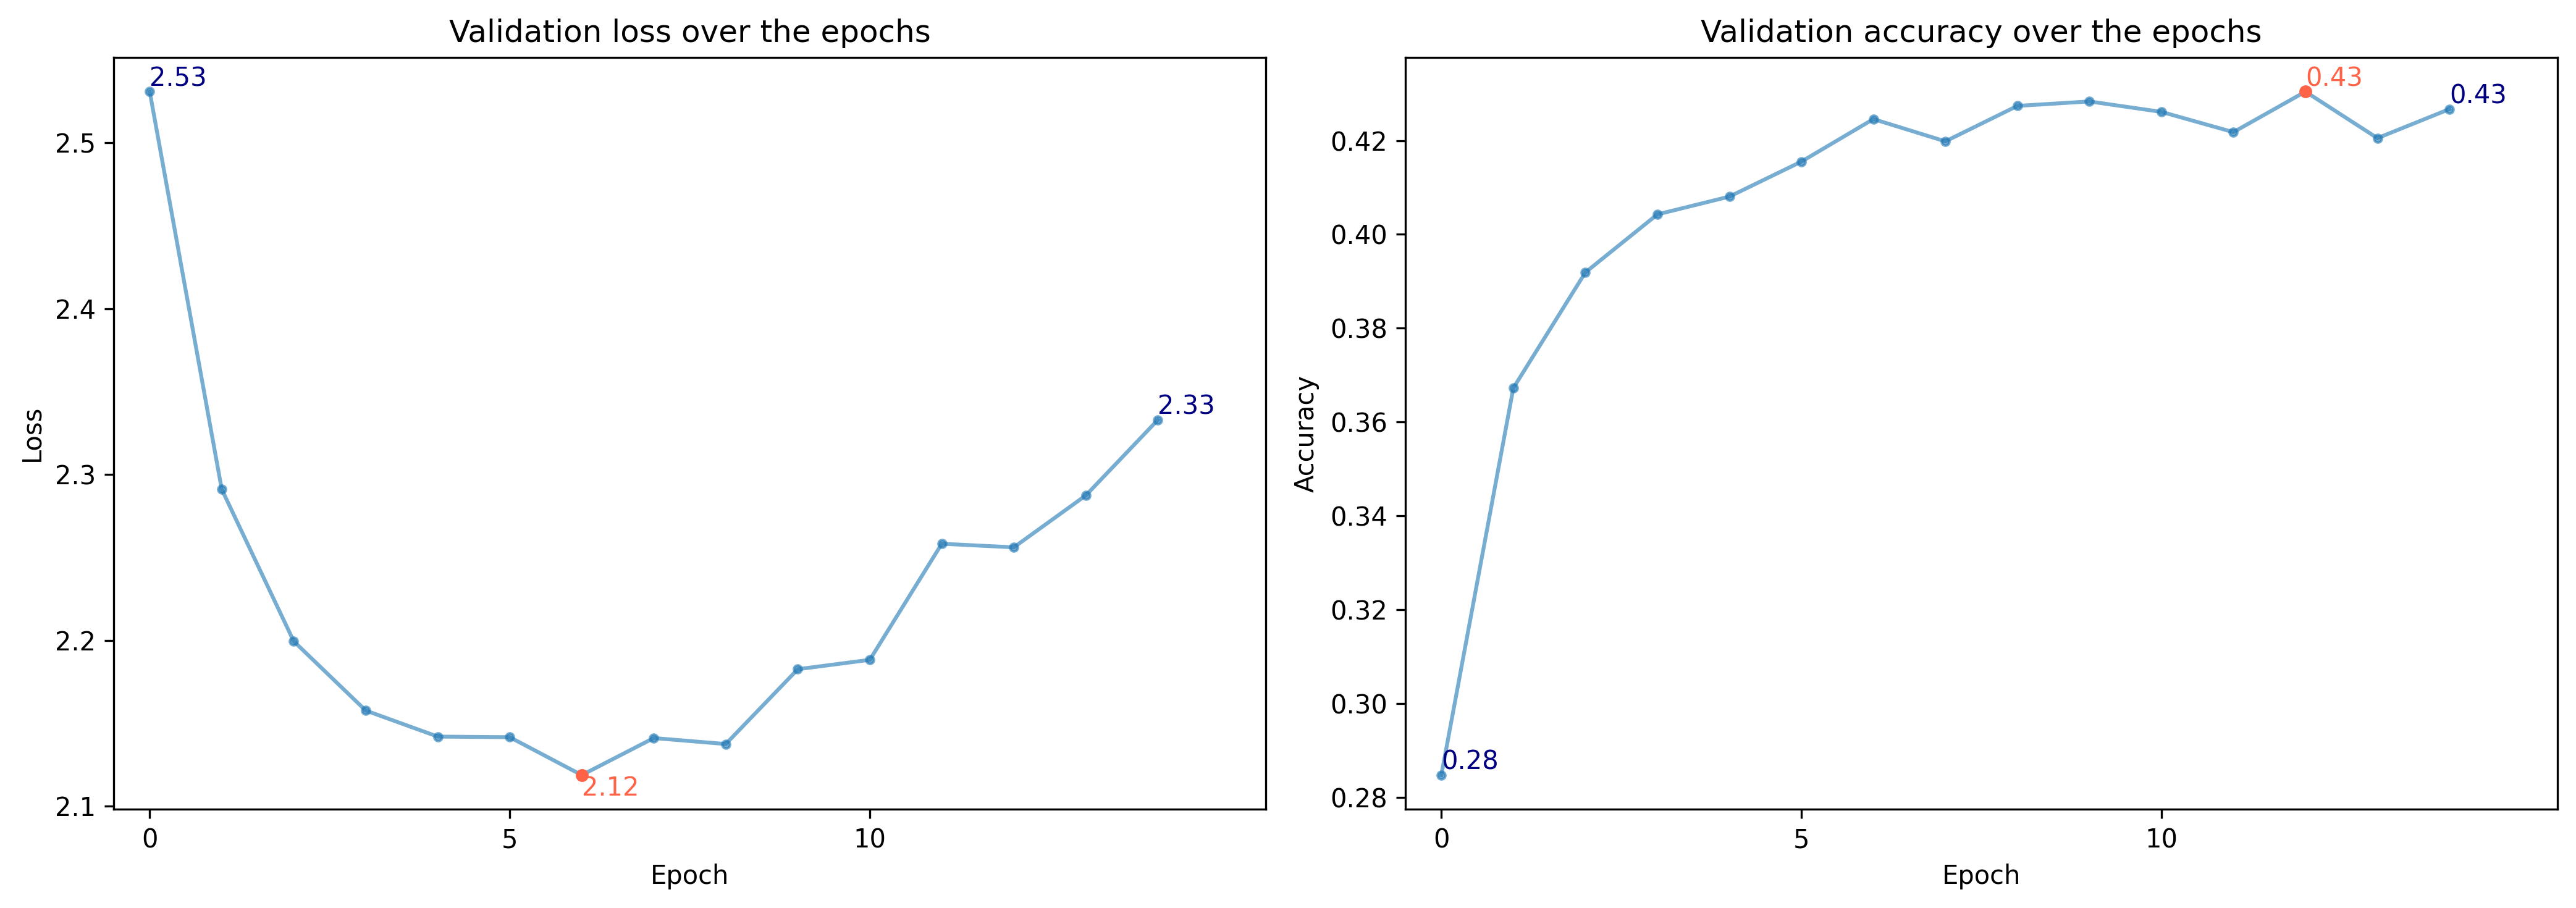

In [ ]:
# Loss and accuracy

plt.figure(figsize=(14, 5), dpi=300)

plt.subplot(1, 2, 1)
# plot losses and highlight lowest value
plt.plot(losses, label='Validation Loss', marker='o', markersize=3, alpha = 0.6)
plt.plot(np.argmin(losses), np.min(losses), marker='o', markersize=4, color="tomato")

# print losses on first, last and lowest value
plt.text(0, losses[0], f'{losses[0]:.2f}', ha="left", va="bottom", color="navy")
plt.text(np.argmin(losses), losses[np.argmin(losses)], f'{losses[np.argmin(losses)]:.2f}', ha="left", va="top", color="tomato")
plt.text(len(losses) - 1, losses[-1], f'{losses[-1]:.2f}', va="bottom", color="navy")

# other stuff
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(-0.5,len(losses)+0.5)
plt.xticks(np.arange(0, len(losses), 5))
plt.title('Validation loss over the epochs')

plt.subplot(1, 2, 2)
# print accuracies and highlight max
plt.plot(accuracies, label='Validation Accuracy',marker='o', markersize=3, alpha = 0.6)
plt.plot(np.argmax(accuracies), np.max(accuracies), marker='o', markersize=4, color="tomato")

# print accuracies on first, last and max value
plt.text(0, accuracies[0], f'{accuracies[0]:.2f}', ha="left", va="bottom", color="navy")
plt.text(np.argmax(accuracies), accuracies[np.argmax(accuracies)], f'{accuracies[np.argmax(accuracies)]:.2f}', va="bottom", color="tomato")
plt.text(len(accuracies) - 1, accuracies[-1], f'{accuracies[-1]:.2f}', va="bottom", color="navy")

#
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(-0.5,len(accuracies)+0.5)
plt.xticks(np.arange(0, len(accuracies), 5))
plt.title('Validation accuracy over the epochs')

plt.tight_layout()
#plt.savefig('1.png', dpi = 300)   # Saves the plot
plt.show()

Accuracy: 0.42669720268280714
Accuracy over letter predictions: 0.42669720268280714


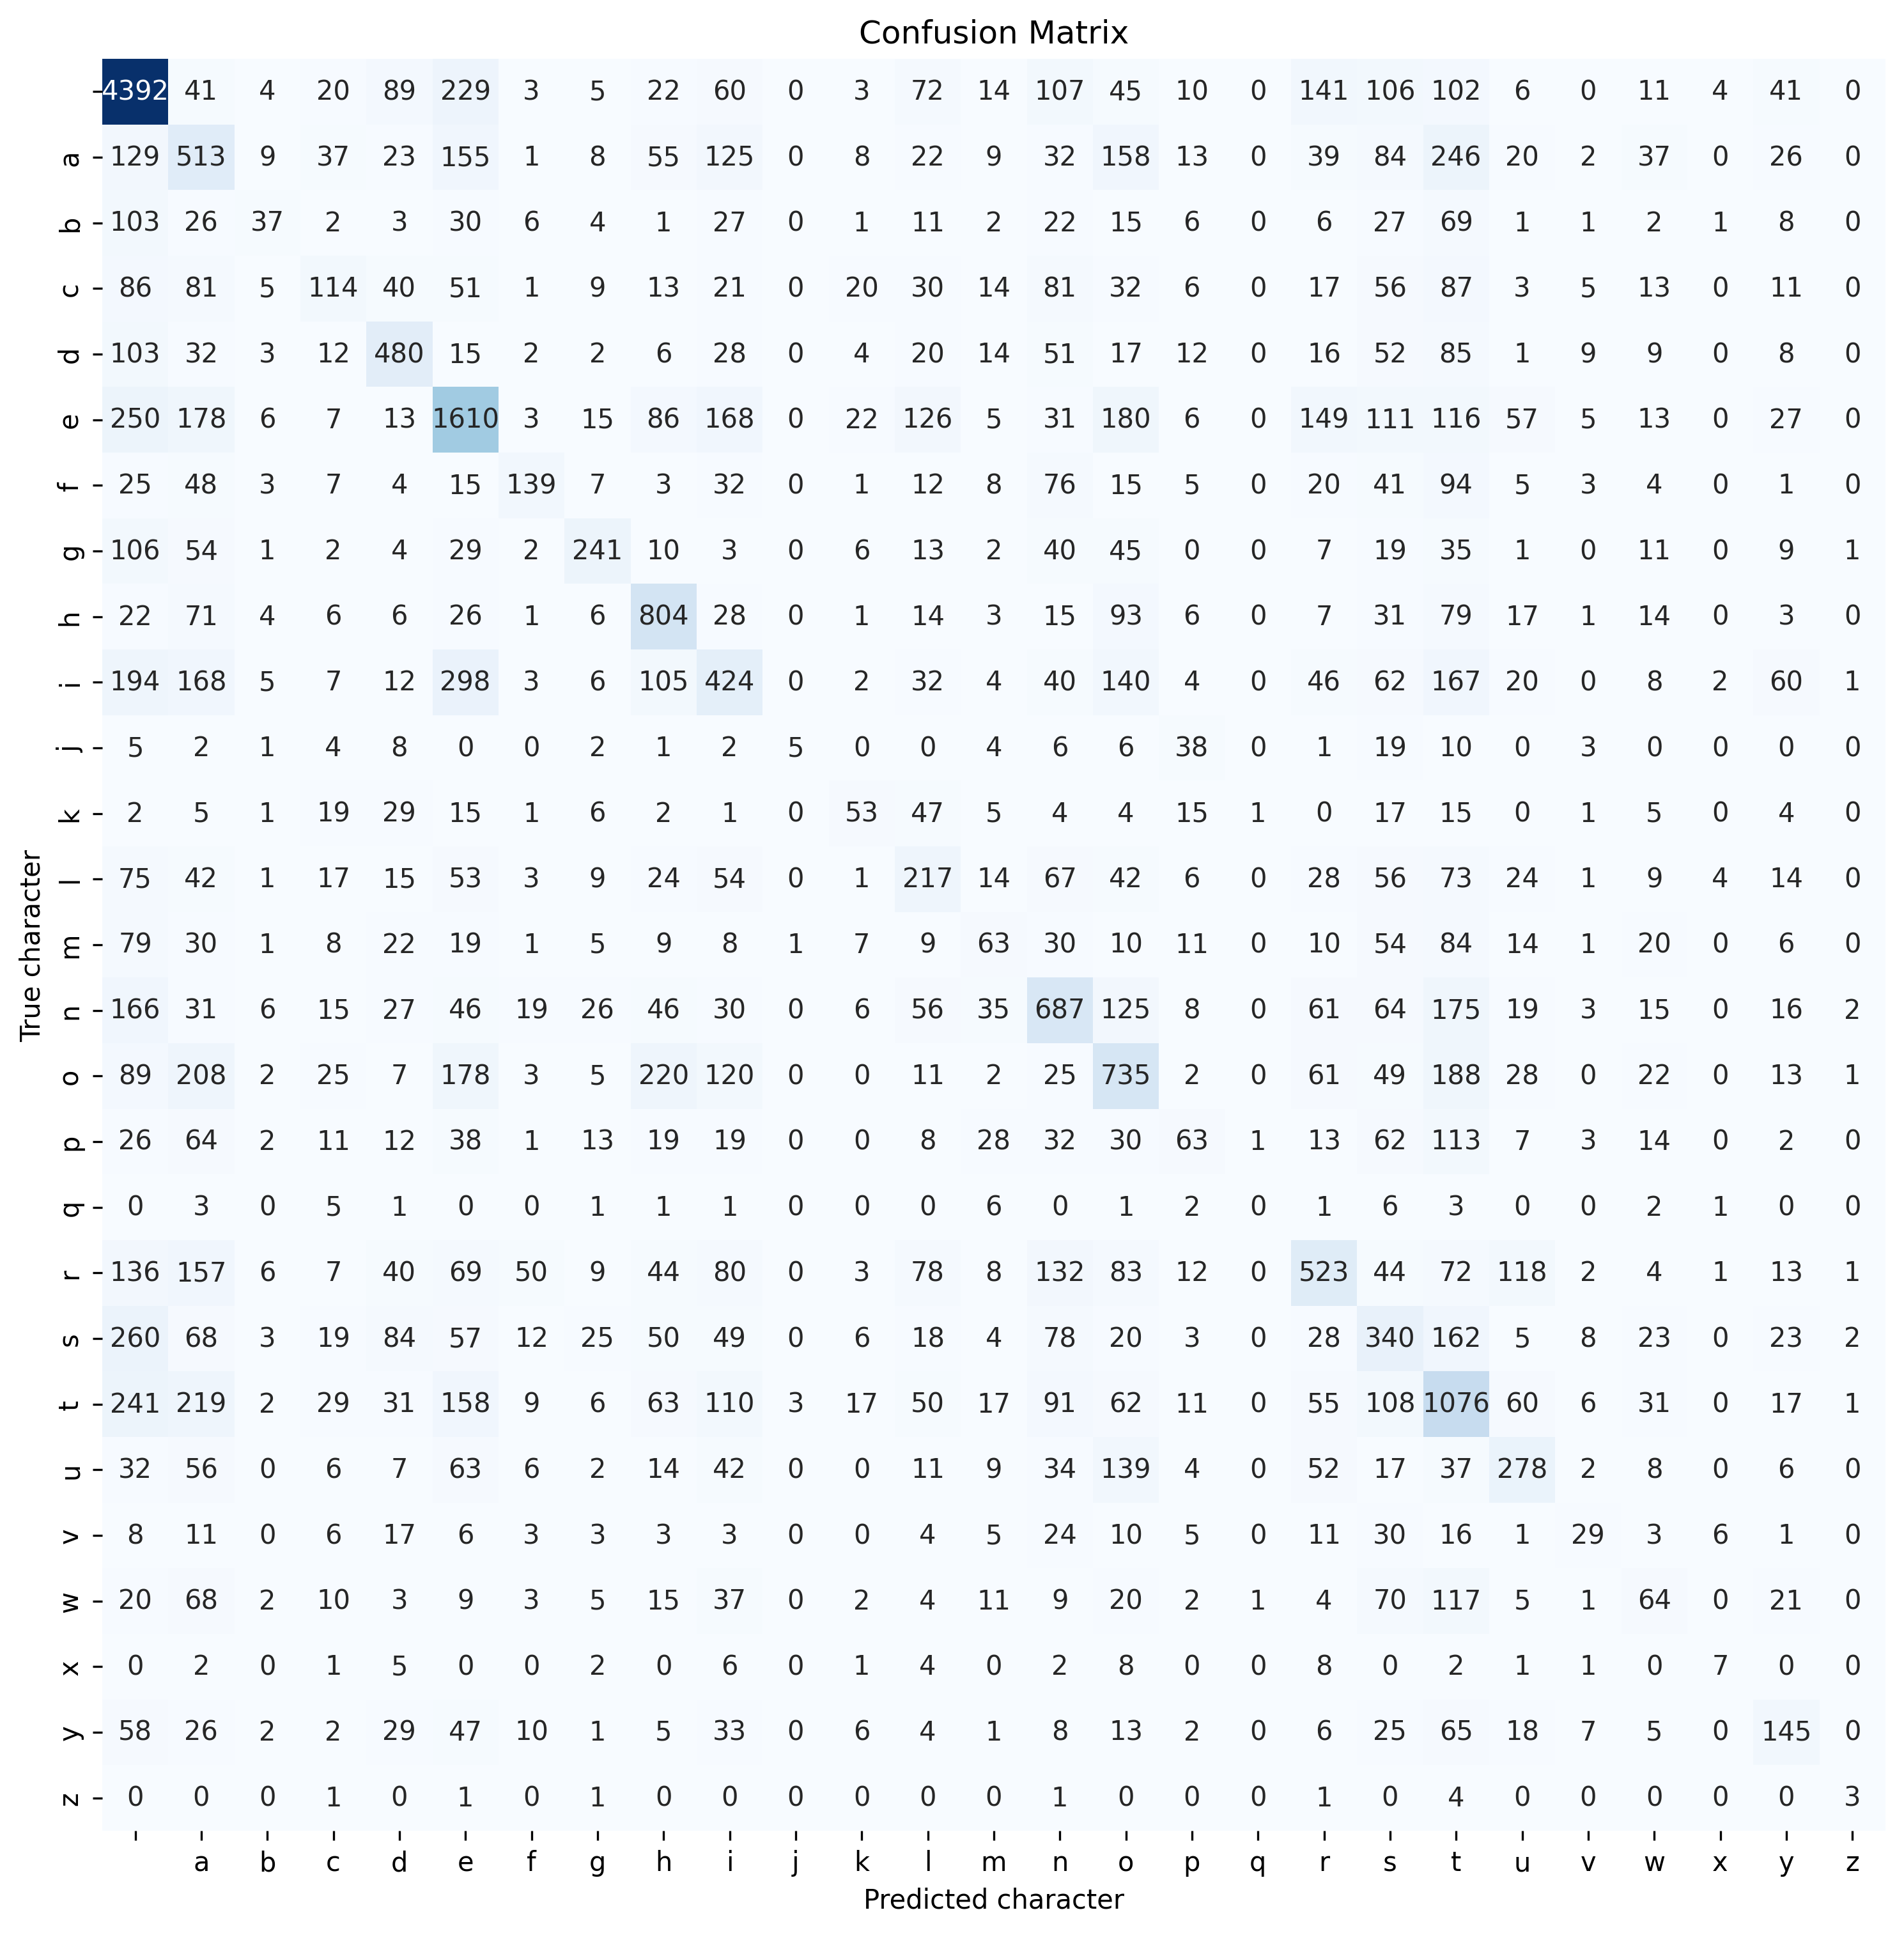

In [ ]:
# Quite ugly

predictions = []
gt = []

with torch.no_grad():
    for X_batch, y_batch in loader_test:
      y_pred = model(X_batch.to(device))
      gt.append(int(y_batch.to(device).item()))
      predictions.append(int(y_pred.argmax().item()))

print(f"Accuracy: {sum(1 for pred, actual in zip(predictions, gt) if pred == actual) / len(gt)}")

# invert char_to_int dict
int_to_char = {value: key for key, value in char_to_int.items()}

# convert predictions and gt back to letters
letters_pred = [int_to_char[num] for num in predictions]
letters_gt = [int_to_char[num] for num in gt]

print(f"Accuracy over letter predictions: {sum(1 for pred, actual in zip(letters_pred, letters_gt) if pred == actual) / len(letters_gt)}")

conf_matrix = confusion_matrix(letters_gt, letters_pred)

plt.figure(figsize=(12, 12), dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=chars, yticklabels=chars, cbar=False)

# Set labels and title
plt.xlabel('Predicted character')
plt.ylabel('True character')
plt.title('Confusion Matrix')

plt.savefig("2.png")
plt.show()

3. Generate text with the model


In [ ]:
def checkrepetitions(generated, n):
    words = []
    word = []
    for num in generated:
        if num != 0:
            word.append(num)
        else:
            if word:  # Append non-empty lists only (bug observed in RNN)
                words.append(word)
                word = []

    words = tuple(tuple(word) for word in words)

    # Iterate over different lengths of agglomerates to check for repetitions
    max_length = min(len(words) // 2 + 1, len(words) + 1)  # Check up to half of the sequence length or less
    for length in range(2, max_length):
        for i in range(length * 2, len(words)):
            if words[i - length : i] == words[i - length * 2 : i - length]:
                return f"\n\nWarning! {length} words repetition after {n} generations"

    return "GO"


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import random

# Load the best model and character mapping dictionary
best_model, char_to_int = torch.load("single-char.pth")

# Get vocabulary size from the character mapping dictionary
n_vocab = len(char_to_int)

# Create a dictionary for converting integer indices back to characters
int_to_char = dict((i, c) for c, i in char_to_int.items())

# Create a model instance and load the weights from the saved model
model = CharModel(n_vocab)                                                          ## CharModel, CharModelRNN, CharModelGRU
model.load_state_dict(best_model)
model.to(device)  # Move the model to the appropriate device (CPU or GPU)

# Generate random starting indices
n_generations = 20
starts = np.random.randint(0, len(raw_text)-seq_length, n_generations)

# Set model to evaluation mode (no gradients needed during generation)
model.eval()

# Text Generation Loop
lasting = []
for s in starts:
  # Extract the prompt (sequence of characters) based on the starting index
  prompt = raw_text[s:s+seq_length]

  # Convert the characters in the prompt to integer indices using the character mapping dictionary
  pattern = [char_to_int[c] for c in prompt]

  print(f"Sequence {s}")
  print('\tPrompt: "%s"' % prompt)
  print("\tGenerated: ", end="")

  n_characters_to_predict = 100     #500 default
  generated = []
  state ="GO"
  with torch.no_grad():  # Disable gradient calculation for efficiency
    for i in range(n_characters_to_predict):
      if state == "GO":
        # Prepare the input for the model:
        #   - Reshape the pattern list into a PyTorch tensor with dimensions (1, sequence_length, 1)
        #   - Normalize the input by dividing by the vocabulary size (n_vocab)
        #   - Convert the NumPy array to a PyTorch tensor with float32 data type
        ##  – how long is the sentence before it's start to get repetitive?!?!?!?
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        x = torch.tensor(x, dtype=torch.float32)

        # Move the input tensor to the device (CPU or GPU)
        x = x.to(device)

        # Generate logits using the model
        prediction = model(x)

        # Get the index of the predicted character with the highest probability
        index = int(prediction.argmax())
        result = int_to_char[index]

        ## Randomly changing the result with 2% prob (around 2 characters on the whole generation)
        #if random.random() < 0.02:
          #result = random.choice(chars)

        # Print the generated character
        print(result, end="")

        # Update the pattern for the next iteration:
        #   - Append the predicted character index to the pattern list
        #   - Slice the pattern list to keep the most recent sequence length characters
        pattern.append(index)
        pattern = pattern[1:] # removes the first characters because a new one is added and the model works only with 100 inputs!!!
        generated.append(index)
        state = (checkrepetitions(generated, i))
      else:
        print(state)
        lasting.append(i)
        break

  print("\n")

print(f"Over {n_generations} prompts, the generated text gets repetitive after an average of {int(round(np.mean(lasting),0))} generations")

Sequence 136969
	Prompt: "edistribution  start full license the full project gutenberg license please read this before you dis"
	Generated: h the dodo sure it was the dodo sure it was the 

Warning! 5 words repetition after 47 generations


Sequence 142787
	Prompt: "ng any word processing or hypertext form however if you provide access to or distribute copies of a "
	Generated: terpent said the dormouse went on the dodo sure the dormouse went on the dodo sure the 

Warning! 7 words repetition after 86 generations


Sequence 49509
	Prompt: "f the mushroom and crawled away in the grass merely remarking as it went one side will make you grow"
	Generated:  the dormouse went on the dodo sure the dormouse went on the dodo sure the 

Warning! 7 words repetition after 74 generations


Sequence 3271
	Prompt: "shelves here and there she saw maps and pictures hung upon pegs she took down a jar from one of the "
	Generated: dormouse went on the dodo sure the dormouse went on the dodo sure the dorm